In [1]:
import sys 
sys.path.append('../')
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import numpy as np
import torch.nn.functional as F
import scipy
import pandas as pd
import glob
import scienceplots
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
plt.style.use('science')
pd.set_option('display.float_format', lambda x: '%.4e' % x)
# import seaborn as sns


In [2]:
exp_hists = sorted(glob.glob('../results/*/*/hist.csv'))
# exp_kernels = glob.glob('../results/*/*/approx_kernel.npy')

In [3]:
test_rl2_dict = {}
task_nm_lst = []
method_nm_lst = []
seed_lst = []
rl2_lst = []
k_lst = []
m_lst = []
r_lst = []
h_lst = []
act_lst = []
train_lst = []

for exp_hist in exp_hists:
    hist_df = pd.read_csv(exp_hist)
    task_nm = exp_hist.split('/')[2]

    if 'DD_GMGN1D' in exp_hist:
        method_nm, act, res, h, k, m, seed = exp_hist.split('/')[3].split('-')[:7]
    elif 'DD_GMGN2D' in exp_hist:
        method_nm, act, res, h, k, m, seed = exp_hist.split('/')[3].split('-')[:7]
    elif 'Toep_GMGN1D' in exp_hist:
        method_nm, act, res, h, k, m, seed = exp_hist.split('/')[3].split('-')[:7]
    elif 'GN1D' in exp_hist:
        method_nm, act, res, h, seed = exp_hist.split('/')[3].split('-')[:5]
        k, m = 0, 0
    elif 'GN2D' in exp_hist:
        method_nm, act, res, h, seed = exp_hist.split('/')[3].split('-')[:5]
        k, m = 0, 0
    else:
        continue
    
    k, m, h = int(k), int(m), int(h)  


    task_nm_lst.append(task_nm)
    method_nm_lst.append(method_nm)
    seed_lst.append(seed)
    rl2_lst.append(hist_df.test_rl2.iloc[-1])
    k_lst.append(k)
    m_lst.append(m)
    h_lst.append(h)
    r_lst.append(res)
    act_lst.append(act)
    train_lst.append(hist_df.train_rl2)

test_rl2_dict = {
    'rl2' : rl2_lst, 
    'task' : task_nm_lst,
    'method' : method_nm_lst,
    'seed' : seed_lst,
    'act' : act_lst,
    'train' : train_lst,
    'r' : r_lst,
    'k' : k_lst,
    'm' : m_lst,
    'h' : h_lst,
}

test_rl2_df = pd.DataFrame(test_rl2_dict)

In [4]:
def plot_m_trend(df, task_nm, method_nm, res, act):
    pparam = dict(xlabel='$m$', ylabel=r'Relative error')
    fig, ax = plt.subplots()
    for k in [1,3,5,7]:
        sub_df = df[
            (df.method == method_nm) & \
            (test_rl2_df.task == task_nm) & \
            (test_rl2_df.k == k) & \
            (test_rl2_df.act == act) & \
            (test_rl2_df.r == res)].sort_values(by='m')
        rl2_df = sub_df.groupby(['m']).agg({'rl2':'mean'})
        ax.scatter(rl2_df.index.values[:-1], rl2_df['rl2'].values[:-1], label=k)       

    # ax.autoscale(tight=True)
    ax.set_yscale('log')
    ax.legend(title='coarse level')
    ax.set(**pparam)  
    return sub_df

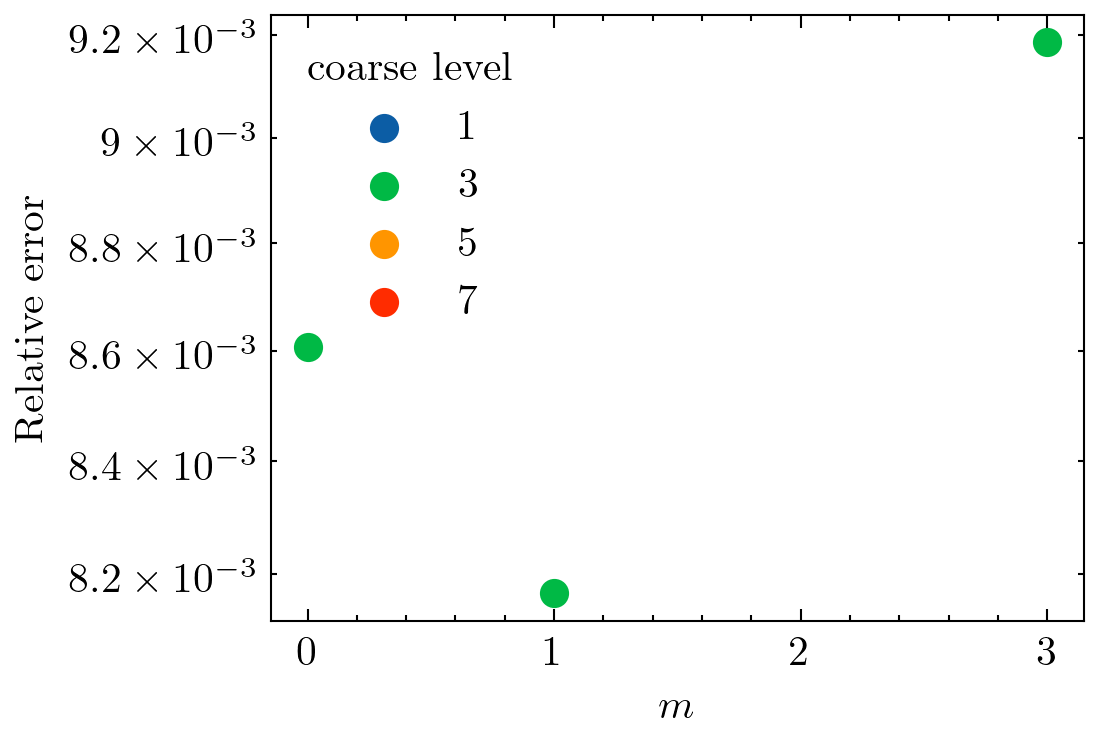

In [5]:
sub_df = plot_m_trend(test_rl2_df, 'expdecay', 'DD_GMGN1D', '2049', 'relu')

In [6]:
test_rl2_df[(test_rl2_df.task == 'expdecay') & (test_rl2_df.method == 'GN1D') ].groupby(['task', 'act', 'method', 'r', 'k', 'm', 'h']).agg({'rl2':'mean', 'seed':'count'}).sort_values('r')

rl2  seed
task     act  method r    k m h                  
expdecay relu GN1D   1025 0 0 50 8.7137e-03     5
                     2049 0 0 50 8.1526e-03     4
                     4097 0 0 50 8.2595e-03     3
                     513  0 0 50 9.1415e-03     3

In [7]:
test_rl2_df[(test_rl2_df.task == 'expdecay') & (test_rl2_df.method == 'DD_GMGN1D') & (test_rl2_df.r == '513') ].groupby(['task', 'act', 'method', 'r', 'k', 'm', 'h']).agg({'rl2':'mean', 'seed':'count'})

rl2  seed
task     act  method    r   k m  h                  
expdecay relu DD_GMGN1D 513 1 0  50 7.8951e-03     2
                              1  50 9.5292e-03     2
                              3  50 1.0333e-02     2
                              5  50 9.5560e-03     2
                              7  50 9.6073e-03     2
                              15 50 8.5209e-03     2
                              31 50 7.3917e-03     2
                            3 0  50 1.3583e-02     2
                              1  50 1.3529e-02     2
                              3  50 1.0905e-02     2
                              5  50 9.6177e-03     2
                              7  50 1.0005e-02     2
                              15 50 9.2427e-03     2
                              31 50 8.4654e-03     2
                            5 0  50 6.7490e-02     2
                              1  50 2.2291e-02     2
                              3  50 1.3437e-02     2
                              5  50 1.1682e-02     2
                              7  50 1.1510e-02     2
                              15 50 1.0961e-02     2
                              31 50 1.0065e-02     2
                            7 0  50 5.6216e-01     2
                              1  50 2.6280e-02     2
                              3  50 1.5545e-02     2
                              5  50 1.1587e-02     2
                              7  50 1.2273e-02     2
                              15 50 1.1774e-02     2
                              31 50 1.6788e-02     2

In [8]:
test_rl2_df[(test_rl2_df.task == 'poisson') & (test_rl2_df.method == 'DD_GMGN1D') & (test_rl2_df.m > 0) ]

,rl2,task,method,seed,act,train,r,k,m,h
214,2.0271e-03,poisson,DD_GMGN1D,0,relu,0 5.9256e-01 1 5.2042e-01 2 4.5...,1025,1,1,50
217,2.6145e-03,poisson,DD_GMGN1D,0,relu,0 5.9320e-01 1 5.2100e-01 2 4.6...,1025,2,1,50
218,1.2656e-03,poisson,DD_GMGN1D,1,relu,0 9.8514e-01 1 6.4120e-01 2 6.3...,1025,2,1,50
219,2.2146e-03,poisson,DD_GMGN1D,0,relu,0 5.9320e-01 1 5.2100e-01 2 4.6...,1025,2,15,50
220,1.7863e-03,poisson,DD_GMGN1D,0,relu,0 5.9320e-01 1 5.2100e-01 2 4.6...,1025,2,3,50
221,1.5461e-03,poisson,DD_GMGN1D,1,relu,0 9.8514e-01 1 6.4120e-01 2 6.3...,1025,2,3,50
222,1.3372e-03,poisson,DD_GMGN1D,0,relu,0 5.9320e-01 1 5.2100e-01 2 4.6...,1025,2,5,50
223,1.1161e-03,poisson,DD_GMGN1D,1,relu,0 9.8514e-01 1 6.4120e-01 2 6.3...,1025,2,5,50
224,1.2744e-03,poisson,DD_GMGN1D,0,relu,0 5.9320e-01 1 5.2100e-01 2 4.6...,1025,2,7,50
225,1.1752e-03,poisson,DD_GMGN1D,1,relu,0 9.8514e-01 1 6.4120e-01 2 6.3...,1025,2,7,50


In [9]:
test_rl2_df[(test_rl2_df.task == 'expdecay') & (test_rl2_df.method == 'DD_GMGN1D') ].groupby(['task', 'act', 'method', 'r', 'k', 'm', 'h']).agg({'rl2':'mean', 'seed':'count'})

rl2  seed
task     act      method    r    k m  h                  
expdecay rational DD_GMGN1D 4097 7 65 50 3.8527e-03     1
         relu     DD_GMGN1D 1025 1 0  50 8.1311e-03     2
                                   1  50 8.4488e-03     2
                                   3  50 8.4548e-03     2
                                   5  50 8.0048e-03     2
                                   7  50 8.2715e-03     2
                                   15 50 8.6227e-03     2
                                 2 0  50 8.0060e-03     2
                                   1  50 9.1191e-03     2
                                   3  50 1.0193e-02     2
                                   5  50 7.1808e-03     2
                                   7  50 9.3975e-03     2
                                   15 50 8.8018e-03     2
                                 3 0  50 9.8406e-03     2
                                   1  50 8.4863e-03     2
                                   3  50 8.9228e-03     2
                                   5  50 9.5114e-03     2
                                   7  50 1.0168e-02     2
                                   15 50 8.1850e-03     2
                            2049 3 0  50 8.6065e-03     2
                                   1  50 8.1661e-03     2
                                   3  50 9.1856e-03     2
                                   5  50 9.1703e-03     2
                            4097 1 0  50 8.7049e-03     1
                                   1  50 6.0936e-03     1
                                   3  50 1.0409e-02     1
                                   7  50 7.6897e-03     1
                                   15 50 7.8257e-03     1
                                   31 50 7.2004e-03     1
                                   65 50 6.5066e-03     1
                                 3 0  50 8.2470e-03     1
                                   1  50 7.5830e-03     1
                                   3  50 1.0358e-02     1
                                   7  50 8.9245e-03     1
                                   15 50 6.6849e-03     1
                                   31 50 9.1937e-03     1
                                   65 50 8.6426e-03     1
                                 5 0  50 8.1377e-03     1
                                   1  50 9.1304e-03     1
                                   3  50 1.1197e-02     1
                                   7  50 9.2882e-03     1
                                   15 50 7.3248e-03     1
                                   31 50 1.0287e-02     1
                                   65 50 8.0034e-03     1
                                 7 0  50 2.1459e-02     1
                                   1  50 1.3593e-02     1
                                   3  50 1.2945e-02     1
                                   7  50 8.3896e-03     1
                                   15 50 7.5418e-03     1
                                   31 50 8.5713e-03     1
                                   65 50 9.1907e-03     3
                            513  3 0  50 1.2283e-02     1
                                   1  50 1.1538e-02     1
                                   3  50 1.1771e-02     1
                                   15 50 7.7275e-03     1
                                   31 50 8.9477e-03     1

Cosine - 513

In [11]:
l = 9
n = 2**l+1
s = 2**(l-1)
x = torch.linspace(-1,1,2*n-1)

A_gt = torch.cos(torch.linspace(-1,1,2*n-1).abs())
A_tgl = np.load('../results/logarithm_513/toep_gl-relu-0/approx_kernel.npy') * s
A_tgmg = np.load('../results/logarithm_513/toep_mg-3-7-0/approx_kernel.npy') * s

hist_tgl = pd.read_csv('../results/logarithm_513/toep_gl-relu-0/hist.csv')
hist_tgmg = pd.read_csv('../results/logarithm_513/toep_mg-3-7-0/hist.csv')
hist_fno = pd.read_csv('../results/logarithm_513/fno-0/hist.csv')


FileNotFoundError: [Errno 2] No such file or directory: '../results/logarithm_513/toep_gl-relu-0/approx_kernel.npy'

Logarithm - 513

In [ ]:
l = 9
n = 2**l+1
s = 2**(l-1)
x = torch.linspace(-1,1,2*n-1)
k = 7
m = 0

if n == 32769:
    posinf = 11.09
elif n == 8193:
    posinf = 9.07
else:
    posinf = 6.9

A_gt = torch.nan_to_num(-torch.log(torch.linspace(-1,1,2*n-1).abs()), posinf=posinf)
A_tgl = np.load('../results/logarithm_513/toep_gl-relu-0/approx_kernel.npy') * s
A_tgmg = np.load('../results/logarithm_513/toep_mg-3-0-0/approx_kernel.npy') * s
A_tgmg7 = np.load('../results/logarithm_513/toep_mg-3-7-0/approx_kernel.npy') * s

hist_tgl = pd.read_csv('../results/logarithm_513/toep_gl-relu-0/hist.csv')
hist_tgmg = pd.read_csv('../results/logarithm_513/toep_mg-3-0-0/hist.csv')
hist_tgmg7 = pd.read_csv('../results/logarithm_513/toep_mg-3-7-0/hist.csv')
hist_fno = pd.read_csv('../results/logarithm_513/fno-0/hist.csv')

Visualize Kernel

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(x, A_gt, '-k', label='analytic')
ax.plot(x, A_tgmg, '-g', label='TGMG-m0')
ax.plot(x, A_tgmg7, '-r', label='TGMG-m7')
ax.plot(x, A_tgl, '-b', label='TGL')


axins = ax.inset_axes([-.3, 0.3, 0.6, 0.6], xlim=(-0.1, 0.1), ylim=(2,10))
axins.plot(x, A_gt, '-k', label='analytic')
axins.plot(x, A_tgl, '-b', label='TGL')
axins.plot(x, A_tgmg7, '-r', label='TGMG-m7')
axins.plot(x, A_tgmg, '-g', label='TGMG-m0')

ax.indicate_inset_zoom(axins)
ax.legend()

Training Dynamics

In [ ]:
# plt.plot(hist_gl.test_rl2, '-k', label='GL')
plt.plot(hist_tgl.test_rl2, '-b', label='TGL')
plt.plot(hist_tgmg.test_rl2, '-g', label='TGMG-m0')
plt.plot(hist_tgmg7.test_rl2, '-m', label='TGMG-m7')
plt.plot(hist_fno.test_rl2, '-r', label='FNO')
plt.legend()
plt.yscale('log')
# plt.ylim([0, 0.001])
plt.minorticks_on()

In [ ]:
matrl2_error(torch.tensor(A_tgmg7[None]), torch.tensor(A_gt[None]))

In [ ]:
matrl2_error(torch.tensor(A_tgl[None]), torch.tensor(A_gt[None]))

In [ ]:
matrl2_error(torch.tensor(A_tgmg[None]), torch.tensor(A_gt[None]))

Laplace - 513

In [ ]:
l = 13
n = 2**l+1
s = 2**l
x = torch.linspace(0,1,n)

raw_data = scipy.io.loadmat(f'../../pde_data/green_learning/data1d_{n}/laplace.mat')
xh, yh = raw_data['X'], raw_data['Y']
x, y = np.meshgrid(xh, yh)
K_gt = eval(raw_data['ExactGreen'][0]).T

K_lrgl = np.load(f'../results/laplace_{n}/lr_gl-relu-16-0/approx_kernel.npy')[0] * s
K_gmg = np.load(f'../results/laplace_{n}/dd_mg-7-7-0/approx_kernel.npy')[0]*2
K_lrgmg = np.load(f'../results/laplace_{n}/lrdd_mg-5-7-16-0/approx_kernel.npy')[0,0]*2

# hist_gl = pd.read_csv('../results/laplace_513/gl-relu-0/hist.csv')
# hist_gmg = pd.read_csv('../results/laplace_513/dd_mg-5-5-1/hist.csv')
# hist_fno = pd.read_csv('../results/laplace_513/fno-0/hist.csv')

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(figsize=(16, 4), ncols=4)
gmg_fig = ax1.imshow(K_gmg, cmap='jet', vmax=K_gt.max(), vmin=K_gt.min())
ax1.set_title('GreenMG')
fig.colorbar(gmg_fig, ax=ax1, shrink=0.7)
lrgl_fig = ax2.imshow(K_lrgl, cmap='jet', vmax=K_gt.max(), vmin=K_gt.min())
fig.colorbar(lrgl_fig, ax=ax2, shrink=0.7)
ax2.set_title('LRGreenNet')
lrgmg_fig = ax3.imshow(K_lrgmg, cmap='jet', vmax=K_gt.max(), vmin=K_gt.min())
fig.colorbar(lrgmg_fig, ax=ax3, shrink=0.7)
ax3.set_title('LRGreenMG')
gt_fig = ax4.imshow(K_gt, cmap='jet', vmax=K_gt.max(), vmin=K_gt.min())
fig.colorbar(gt_fig, ax=ax4, shrink=0.7)
ax4.set_title('Analytic')
# err_fig = ax4.imshow(np.abs(K_gt-K_gmg), cmap='seismic')
# fig.colorbar(err_fig, ax=ax4, shrink=0.7)
# ax4.set_title('GreenMG-AbsError')

In [ ]:
idx = 5000
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(x[0], K_gt[idx], '-k', label='analytic')
ax.plot(x[0], K_gmg[idx], '-g', label='GreenMG')
ax.plot(x[0], K_lrgl[idx], '-b', label='LRGreenNet')
ax.plot(x[0], K_lrgmg[idx], '-r', label='LRGreenMG')

# ax.set_xlim([0.49, 0.51])
# ax.set_ylim([0.22, 0.26])

In [ ]:
plt.plot(hist_gl.test_rl2, '-b', label='GreenNet')
plt.plot(hist_gmg.test_rl2, '-g', label='GreenMG')
plt.plot(hist_fno.test_rl2, '-r', label='FNO')
plt.legend()
plt.yscale('log')
plt.minorticks_on()

In [ ]:
matrl2_error(torch.tensor(K_gl[None]), torch.tensor(K_gt[None]))

In [ ]:
matrl2_error(torch.tensor(K_gmg[None]), torch.tensor(K_gt[None]))

Schrodinger - 513

In [ ]:
l = 9
n = 2**l+1
s = 2**l
x = torch.linspace(-1,1,2*n-1)

K_gmg = np.load('../results/schrodinger_513/dd_mg-1-3-1/approx_kernel.npy')[0] * s
K_gl = np.load('../results/schrodinger_513/dd_mg-1-3-1/approx_kernel.npy')[0] * s

# K_gmg = np.load('../results/interior_layer_513/dd_mg-0-0-1/approx_kernel.npy')[0] * s


hist_gl = pd.read_csv('../results/schrodinger_513/')
hist_gmg = pd.read_csv('../results/schrodinger_513/dd_mg-0-3-1/hist.csv')
hist_fno = pd.read_csv('../results/schrodinger_513/fno-0/hist.csv')

In [ ]:
plt.imshow(K_gmg)
plt.title('GreenMG')
plt.colorbar()

In [ ]:
plt.plot(hist_gmg.test_rl2, '-g', label='GreenMG')
plt.plot(hist_fno.test_rl2, '-r', label='FNO')
plt.legend()
plt.yscale('log')
plt.minorticks_on()